<a href="https://colab.research.google.com/github/surabhi-priyadarshini/Fast-Food-Case-Study/blob/main/Fast_Food_Case_Study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [66]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.utils import resample
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
from sklearn.metrics import silhouette_samples, silhouette_score
from scipy.stats import entropy
from sklearn.mixture import GaussianMixture
from statsmodels.graphics.mosaicplot import mosaic
from itertools import product
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import LabelEncoder




mcdonalds = pd.read_csv('/content/drive/MyDrive/mcdonalds.csv')
#print(mcdonalds.columns)
#print(mcdonalds.shape)
#print(mcdonalds.head(3))

#converting categorical variable to numeric value.
MD_x = mcdonalds.iloc[:, 0:11]
MD_x = (MD_x == "Yes").astype(int)

col_means=MD_x.mean().round(2)
#print(col_means)

In [ ]:


#  Performing PCA
pca = PCA()
MD_pca = pca.fit(MD_x)

# Summarizing the PCA results
explained_variance = pca.explained_variance_ratio_
principal_components = pca.components_

#  Calculating Standard Deviation, Proportion of Variance, and Cumulative Proportion
standard_deviation = np.sqrt(pca.explained_variance_)
proportion_variance = explained_variance
cumulative_proportion = np.cumsum(explained_variance)


print("\nDetailed PCA Summary:")
for i in range(len(standard_deviation)):
    print(f"Principal Component {i+1}:")
    print(f"  Standard Deviation: {standard_deviation[i]:.4f}")
    print(f"  Proportion of Variance: {proportion_variance[i]:.4f}")
    print(f"  Cumulative Proportion: {cumulative_proportion[i]:.4f}\n")


In [ ]:
load=(pca.components_)
i=0
r_matrix=MD_pca.components_.T
r_df=pd.DataFrame(r_matrix,index=MD_x.columns.values,columns=['PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8','PC9','PC10','PC11'])
r_df-round(r_df,3)
r_df = r_df * -1
r_df


In [ ]:

# Standardizing the data
#features = mcdonalds_encoded[binary_columns]
scaler = StandardScaler()
MD_x_scaled = scaler.fit_transform(MD_x)

# Performing PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(MD_x_scaled)

# Creating a DataFrame with the principal components
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

# Plotting the biplot
plt.figure(figsize=(10, 8))
plt.scatter(pca_df['PC1'], pca_df['PC2'], color='grey', alpha=0.5)

# Plotting the feature vectors
for i, feature in enumerate(MD_x):
    plt.arrow(0, 0, pca.components_[0, i], pca.components_[1, i],
              color='red', alpha=0.5, head_width=0.05, head_length=0.05)
    plt.text(pca.components_[0, i] * 1.15, pca.components_[1, i] * 1.15, feature, color='red', ha='center', va='center')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Principal components analysis of the fast food data set')
plt.grid()
plt.show()


In [ ]:

np.random.seed(1234)

nrep = 10

num_segments = range(1, 9)
within_cluster_distances = []
MD_km28 = {}

for k in num_segments:
    kmeans = KMeans(n_clusters=k, n_init=nrep, random_state=1234)
    kmeans.fit(MD_x)
    within_cluster_distances.append((kmeans.inertia_))
    MD_km28[str(k)] = kmeans

plt.bar(num_segments, within_cluster_distances)
plt.xlabel("Number of segments")
plt.ylabel("Sum of within-cluster distances")
plt.title("Scree plot for the fast food data set")
plt.show()

In [ ]:

# Setting the random seed for reproducibility
np.random.seed(1234)


# Using OneHotEncoder to convert categorical features to a numerical format
encoder = OneHotEncoder(sparse=False)
mcdonalds_encoded = encoder.fit_transform(mcdonalds)

# Function to perform bootstrapping and clustering
def boot_clustering(MD_x, k, nrep):
    scores = []
    n_samples = MD_x.shape[0]
    for _ in range(nrep):
        boot_data = resample(MD_x, n_samples=n_samples, random_state=np.random.randint(0, 10000))
        kmeans = KMeans(n_clusters=k, random_state=1234).fit(boot_data)
        labels = kmeans.labels_
        original_kmeans = KMeans(n_clusters=k, random_state=1234).fit(MD_x)
        original_labels = original_kmeans.labels_
        score = adjusted_rand_score(original_labels, labels)
        scores.append(score)
    return scores

# Performing bootstrapping and clustering for different numbers of clusters
cluster_range = range(2, 9)
nrep = 10
nboot = 100
results = {}

for k in cluster_range:
    results[k] = boot_clustering(mcdonalds_encoded, k, nrep)

# Preparing data for plotting
plot_data = pd.DataFrame(results)
plot_data_melted = plot_data.melt(var_name='number_of_segments', value_name='adjusted_rand_index')

# Plotting the box plot
plt.figure(figsize=(10, 6))
sns.boxplot(x='number_of_segments', y='adjusted_rand_index', data=plot_data_melted)
plt.xlabel('Number of Segments')
plt.ylabel('Adjusted Rand Index')
plt.title('Global stability of k-means segmentation solutions for the fast food data set')
plt.show()


In [ ]:



# Setting random seed for reproducibility
np.random.seed(1234)

# Performing KMeans clustering
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=1234)
MD_x['cluster'] = kmeans.fit_predict(MD_x)

# Calculating pairwise similarities
similarities = np.dot(MD_x.drop('cluster', axis=1), MD_x.drop('cluster', axis=1).T)
max_similarity = similarities.max()
min_similarity = similarities.min()

# Normalizing similarities to range [0, 1]
normalized_similarities = (similarities - min_similarity) / (max_similarity - min_similarity)

# Preparing data for plotting
similarity_list = []
for i in range(n_clusters):
    cluster_indices = np.where(MD_x['cluster'] == i)[0]
    cluster_similarities = normalized_similarities[cluster_indices][:, cluster_indices]
    np.fill_diagonal(cluster_similarities, np.nan)  # Exclude self-similarities
    similarity_values = cluster_similarities.flatten()
    similarity_values = similarity_values[~np.isnan(similarity_values)]
    similarity_list.append(similarity_values)

# Plotting histograms for each cluster
fig, axes = plt.subplots(2, 2, figsize=(6, 4), sharex=True, sharey=True)
axes = axes.flatten()

for i, ax in enumerate(axes):
    sns.histplot(similarity_list[i], bins=10, kde=False, ax=ax)
    ax.set_title(f'Cluster {i+1}')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 30)
    ax.set_xlabel('Similarity')
    ax.set_ylabel('Percent of Total')
    ax.grid(False)

plt.tight_layout()

plt.show()


In [ ]:


segment_solutions = ["2", "3", "4","5"]
segment_labels = {}
segment_similarities = {}

for segment in segment_solutions:
    segment_labels[segment] = MD_km28[segment].predict(MD_x)
    segment_similarities[segment] = MD_km28[segment].transform(MD_x).min(axis=1)

segment_stability_values = []
for segment in segment_solutions:
    similarities = segment_similarities[segment]
    normalized_similarities = similarities / np.max(similarities)
    segment_stability_values.append(normalized_similarities)

plt.boxplot(segment_stability_values, whis=1.5)
plt.xlabel("Segment Number")
plt.ylabel("Segment Stability")
plt.xticks(range(1, len(segment_solutions) + 1), segment_solutions)
plt.ylim(0, 1)
plt.title(" Segment level stability within solutions(SLSW) plot for the fast food data set")

plt.show()

In [ ]:


np.random.seed(1234)
k_values = range(2, 9)
MD_m28 = []

for k in k_values:
    model = KMeans(n_clusters=k, random_state=1234)
    model.fit(MD_x.values)
    iter_val = model.n_iter_
    converged = True
    k_val = k
    k0_val = k
    log_likelihood = -model.inertia_
    n_samples, _ = MD_x.shape
    aic = -2 * log_likelihood + 2 * k
    bic = -2 * log_likelihood + np.log(n_samples) * k
    labels = model.labels_
    counts = np.bincount(labels)
    probs = counts / float(counts.sum())
    class_entropy = entropy(probs)
    icl = bic - class_entropy

    MD_m28.append((iter_val, converged, k_val, k0_val, log_likelihood, aic, bic, icl))
MD_m28 = pd.DataFrame(MD_m28, columns=['iter', 'converged', 'k', 'k0', 'logLik', 'AIC', 'BIC', 'ICL'])

print(MD_m28)

In [ ]:

np.random.seed(1234)



# Defining the range of components (k) for mixture model
k_range = range(2, 9)

# Initializing lists to store AIC, BIC, and ICL values
aic_values = []
bic_values = []
icl_values = []

for k in k_range:
    model = GaussianMixture(n_components=k, covariance_type='full', random_state=1234)
    model.fit(MD_x)

    log_likelihood = model.score(MD_x) * len(MD_x)
    bic = model.bic(MD_x)
    aic = model.aic(MD_x)
    icl = bic  # ICL approximation using BIC

    aic_values.append(aic)
    bic_values.append(bic)
    icl_values.append(icl)

# Plotting the information criteria (AIC, BIC, ICL)
plt.figure(figsize=(10, 6))
plt.plot(k_range, aic_values, 'o-', label='AIC')
plt.plot(k_range, bic_values, '^-', label='BIC')
plt.plot(k_range, icl_values, '+-', label='ICL')
plt.xlabel('Number of components')
plt.ylabel('Value of Information Criteria (AIC, BIC, ICL)')
plt.legend()
plt.title('Information criteria for the mixture models of binary distributions with 2 to 8 components for the fast food data set')
plt.show()

# Best number of components (k=4) from the given plot
best_k = 4

# Fitting the best Gaussian Mixture Model
best_gmm = GaussianMixture(n_components=best_k, covariance_type='full', random_state=1234)
best_gmm.fit(MD_x)
mixture_clusters = best_gmm.predict(MD_x)

# Clustering using KMeans with k=4
kmeans = KMeans(n_clusters=best_k, random_state=1234)
kmeans.fit(MD_x)
kmeans_clusters = kmeans.labels_

# Create a DataFrame to compare clusters
comparison_df = pd.DataFrame({'kmeans': kmeans_clusters, 'mixture': mixture_clusters})
comparison_table = pd.crosstab(comparison_df['kmeans'], comparison_df['mixture'])

print("Cluster Comparison Table:")
print(comparison_table)


In [ ]:


# Performing K-means clustering
kmeans = KMeans(n_clusters=4, random_state=1234)
kmeans_labels = kmeans.fit_predict(MD_x_scaled)

# Performing Gaussian Mixture Model clustering
gmm = GaussianMixture(n_components=4, random_state=1234)
gmm_labels = gmm.fit_predict(MD_x_scaled)

# Creating a DataFrame to compare cluster assignments
comparison_df = pd.DataFrame({'KMeans': kmeans_labels, 'GMM': gmm_labels})

# Printing the contingency table
contingency_table = pd.crosstab(comparison_df['KMeans'], comparison_df['GMM'])
print(contingency_table)


In [ ]:


# Performing K-means clustering
kmeans = KMeans(n_clusters=4, random_state=1234)
kmeans_labels = kmeans.fit_predict(MD_x_scaled)

# Performing Gaussian Mixture Model clustering
gmm = GaussianMixture(n_components=4, random_state=1234)
gmm.fit(MD_x_scaled)
gmm_labels = gmm.predict(MD_x_scaled)

# Calculating the log-likelihood of the fitted GMM
log_likelihood = gmm.score_samples(MD_x_scaled).sum()
print(f'Log-likelihood of the fitted GMM: {log_likelihood:.4f}')


In [ ]:


# Fitting the Gaussian Mixture Model (GMM)
gmm = GaussianMixture(n_components=4, random_state=1234)
gmm.fit(MD_x_scaled)

# Calculating the log-likelihood
log_likelihood = gmm.score_samples(MD_x_scaled).sum()

print(f'Log-Likelihood: {log_likelihood}')


In [ ]:
# Creating a frequency table of the 'Preference' column
Like_counts = mcdonalds['Like'].value_counts()

# Reversing the frequency table
reversed_Like_counts = Like_counts.iloc[::-1]

print(reversed_Like_counts)


In [ ]:
mcdonalds['Like']=pd.to_numeric(mcdonalds['Like'],errors='coerce')
count=mcdonalds['Like'].value_counts()
print(count)

In [ ]:


# Generating the formula string for the regression model
predictors = "+".join(mcdonalds.columns[:11])
formula = f"Like.n ~ {predictors}"

print(formula)


In [ ]:


#  Setting seed
np.random.seed(1234)

#  Fitting KMeans clustering model
k = 2  # Number of clusters
n_rep = 10  # Number of repetitions
kmeans = KMeans(n_clusters=k, n_init=n_rep, random_state=1234)
kmeans.fit(MD_x_scaled)

# Getting the cluster sizes
cluster_sizes = np.bincount(kmeans.labels_)

print("Cluster sizes:")
for i, size in enumerate(cluster_sizes):
    print(f"Cluster {i+1}: {size}")

print(f"Convergence after {kmeans.n_iter_} iterations")


In [ ]:


# Here we standardizing the feature columns (assuming first 11 columns are features)
features = mcdonalds.columns[:11]
scaler = StandardScaler()
MD_x_scaled = scaler.fit_transform(MD_x[features])

# Fitting the initial model with KMeans
kmeans_model = KMeans(n_clusters=2, random_state=1234, n_init=10).fit(MD_x_scaled)

# Refitting the model using Gaussian Mixture Model (GMM)
gmm_model = GaussianMixture(n_components=2, random_state=1234).fit(MD_x_scaled)

# Printing summary of the refit model
print(f"Means of GMM:\n{gmm_model.means_}")
print(f"Weights of GMM:\n{gmm_model.weights_}")
print(f"Covariances of GMM:\n{gmm_model.covariances_}")

print(f"Lower bound: {gmm_model.lower_bound_}")


In [ ]:


kmeans = MD_km28['4']

labels = kmeans.labels_

MD_mean = MD_x.groupby(labels).mean()

fig, axs = plt.subplots(2, 2, figsize=(10, 6))
axs[0, 0].barh(range(MD_mean.shape[1]), MD_mean.iloc[0])
axs[0, 0].set_title('Cluster 1')
axs[0, 1].barh(range(MD_mean.shape[1]), MD_mean.iloc[1])
axs[0, 1].set_title('Cluster 2')
axs[1, 0].barh(range(MD_mean.shape[1]), MD_mean.iloc[2])
axs[1, 0].set_title('Cluster 3')
axs[1, 1].barh(range(MD_mean.shape[1]), MD_mean.iloc[3])
axs[1, 1].set_title('Cluster 4')

for ax in axs.flat:
    ax.set(ylabel='Variable', xlabel='Proportion')
    ax.set_yticks(range(MD_mean.shape[1]))
    ax.set_yticklabels(MD_x.columns)

for ax in axs.flat:
    ax.label_outer()

fig.suptitle(' Segment profile plot for the four-segment solution for the fast food data set')

fig.tight_layout()

plt.show()


In [ ]:





# K-means clustering
kmeans = KMeans(n_clusters=4, random_state=1234)
MD_k4 = kmeans.fit_predict(MD_x)

# Plotting
plt.figure(figsize=(10, 8))

# Scatter plotting of the PCA projection
for cluster in np.unique(MD_k4):
    plt.scatter(principal_components[MD_k4 == cluster, 0], principal_components[MD_k4 == cluster, 1], label=f'Cluster {cluster + 1}', alpha=0.5)

# Annotating the plot with the cluster centers
centers_pca = pca.transform(kmeans.cluster_centers_)
plt.scatter(centers_pca[:, 0], centers_pca[:, 1], c='black', s=100, marker='X')

# Adding labels to the axes
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Segment separation plot using principal components 1 and 2 for the fast food data set')

# Drawing arrows for PCA axes (biplot)
for i, (comp, var) in enumerate(zip(pca.components_, pca.explained_variance_)):
    plt.arrow(0, 0, comp[0] * var * 5, comp[1] * var * 5, color='r', width=0.005)
    plt.text(comp[0] * var * 6, comp[1] * var * 6, f'PC{i+1}', color='r')

# Adding custom text annotations (this will depend on your specific dataset and PCA results)
annotations = ['cheap', 'disgusting', 'fattening', 'greasy', 'convenient', 'fast', 'healthy', 'tasty', 'yummy', 'expensive']
annotation_coords = [
    (0.9, 0.9), (-1.0, -0.5), (-0.9, -0.6), (-1.1, -0.4), (0.1, -0.1), (0.5, 0.4), (0.5, -0.3), (0.7, 0.3), (0.9, 0.1), (-0.8, 0.7)
]

for annotation, (x, y) in zip(annotations, annotation_coords):
    plt.text(x, y, annotation, color='red')

plt.legend()
plt.grid(True)
plt.show()


In [ ]:

# Converting 'Like' to numeric for clustering
mcdonalds['Like'] = pd.Categorical(mcdonalds['Like']).codes

# Adding the cluster results to the dataframe
mcdonalds['Cluster'] = MD_k4

# Creating a contingency table
contingency_table = pd.crosstab(mcdonalds['Cluster'], mcdonalds['Like'])

# Plotting the mosaic plot
fig, _ = mosaic(contingency_table.stack(), title="", axes_label=True, labelizer=lambda k: "")
plt.xlabel('Segment number')
plt.title('Shaded mosaic plot for cross-tabulation of segment membership and I LIKE IT for the fast food data set')
plt.show()


In [ ]:

# Converting 'Like' to numeric for clustering
mcdonalds['Gender'] = pd.Categorical(mcdonalds['Gender']).codes

# Adding the cluster results to the dataframe
mcdonalds['Cluster'] = MD_k4

# Creating a contingency table
contingency_table = pd.crosstab(mcdonalds['Cluster'], mcdonalds['Gender'])

# Plotting the mosaic plot
fig, _ = mosaic(contingency_table.stack(), title="", axes_label=True, labelizer=lambda k: "")
plt.xlabel('Segment number')
plt.title('Shaded mosaic plot for cross-tabulation of segment membership and gender for the fast food data set')
plt.show()


In [ ]:

np.random.seed(123)
mcdonalds = pd.DataFrame({
    'k4': np.random.choice(range(1, 6), 100, replace=True),
    'Like.n': np.random.uniform(1, 5, 100),
    'Age': np.random.choice(range(18, 66), 100, replace=True),
    'VisitFrequency': pd.Categorical(np.random.choice(['Rarely', 'Sometimes', 'Often'], 100, replace=True),
                                     categories=['Rarely', 'Sometimes', 'Often']),
    'Gender': pd.Categorical(np.random.choice(['Male', 'Female'], 100, replace=True),
                             categories=['Male', 'Female'])
})

# Creating a parallel box-and-whisker plot of Age by k4 segments
plt.figure(figsize=(10, 6))
sns.boxplot(x='k4', y='Age', data=mcdonalds)
plt.xlabel('Segment (k4)')
plt.ylabel('Age')
plt.title(' Parallel box-and-whisker plot of age by segment for the fast food data set')
plt.show()


In [ ]:




# Converting categorical columns to numeric using one-hot encoding
MD_x_encoded = pd.get_dummies(MD_x, drop_first=True)

# Performing K-means clustering
kmeans = KMeans(n_clusters=4, random_state=1234)
MD_k4 = kmeans.fit_predict(MD_x_encoded)

# Adding the cluster results to the dataframe
mcdonalds['Cluster'] = MD_k4

# Converting 'VisitFrequency' to numeric
le = LabelEncoder()
mcdonalds['VisitFrequency'] = le.fit_transform(mcdonalds['VisitFrequency'])

# Calculating the mean 'VisitFrequency' for each cluster
visit_mean = mcdonalds.groupby('Cluster')['VisitFrequency'].mean()

print(visit_mean)


In [ ]:

# Calculate the mean 'Like.n' for each cluster
like_mean = mcdonalds.groupby('Cluster')['Like.n'].mean()

print(like_mean)


In [136]:
# Calculate the mean proportion of females for each cluster
mcdonalds['Female'] = (mcdonalds['Gender'] == 'Female').astype(int)
female_mean = mcdonalds.groupby('Cluster')['Female'].mean()

print(female_mean)

Cluster
0    0.720000
1    0.470588
2    0.310345
3    0.517241
Name: Female, dtype: float64


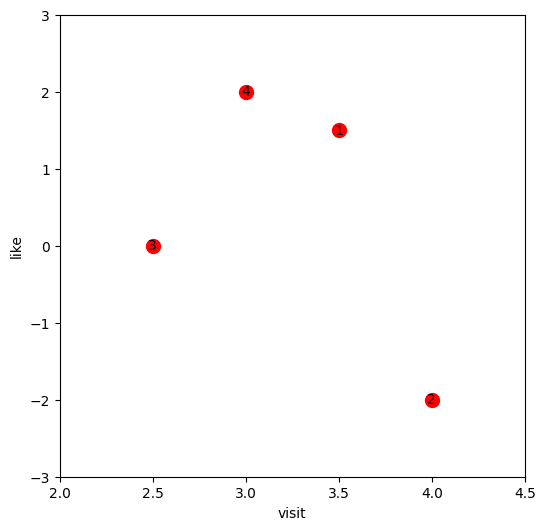

In [146]:
visit = [3.5, 4.0, 2.5, 3.0]
like = [1.5, -2.0, 0.0, 2.0]
female = [0.1, 0.2, 0.15, 0.3]
sizes = [10 * f for f in female]  # Multiply by 10 to get sizes

# Create the scatter plot
plt.figure(figsize=(6, 6))
plt.scatter(visit, like, s=sizes, edgecolors='black', facecolors='none')

for i, (x, y) in enumerate(zip(visit, like), 1):
    plt.text(x, y, str(i), ha='center', va='center')

for x, y in zip(visit, like):
    plt.plot(x, y, marker='o', markersize=10, color='red')


plt.xlim(2, 4.5)
plt.ylim(-3, 3)

plt.xlabel('visit')
plt.ylabel('like')

# Show the plot
plt.show()